# The SAGA algorithm


The SAGA algorithm (stochastic average gradient augmented [Defazio 2014]) is a relatively recent algorithm with very favorable scalability properties. In this lecture we will implement such algorithm and discuss some of its properties.

SAGA belong to the family of stochastic gradient descent (SGD) methods. However, unlike plain SGD it stores the previous gradients and has better convergence properties.

As before, we consider the problem of minimizing a finite sum of convex terms:
$$
\text{argmin}_{\theta} \frac{1}{n} \sum_{i=1}^n l_i(\theta)
$$

The basic algorithm is relies on two moving quantities: a vector of coefficients $\theta \in \mathbb{R}^p$ and a table $g \in \mathbb{R}^{n \times p}$ to store the previous gradients. Then the basic iteration is given by the recursion 


$$
\theta^+ = \theta - \gamma (\nabla l_i(\theta) - g_i + \bar{g}), \quad g_i^+ = \nabla l_i(\theta)
$$


Note that we will be considering the smooth optimization problems. Hence, compared to the course notes $\psi=0$ and the proximal operator does not appear in the optimization $(\text{prox}(x|\psi) = x)$.

### References

[DSOML Course slides 4](http://marcocuturi.net/Teaching/ENSAE/2017/DSOML/DSOML4.pdf)

Defazio, Aaron, Francis Bach, and Simon Lacoste-Julien. ["SAGA: A fast incremental gradient method with support for non-strongly convex composite objectives."](https://arxiv.org/abs/1407.0202) Advances in Neural Information Processing Systems. 2014.

Leblond, Rémi, Pedregosa, Fabian, and Lacoste-Julien, Simon. [ASAGA: Asynchronous Parallel SAGA](https://arxiv.org/abs/1606.04809) Proceedings of the 20th International Conference on Artificial Intelligence and Statistics (AISTATS 2017), 2017.


Defazio, Aaron. ["A simple practical accelerated method for finite sums."](https://arxiv.org/abs/1602.02442) Advances In Neural Information Processing Systems. 2016.

---

In this class we will code an efficient version of this algorithm. This will be divided in the following steps:

  1. **Naive implementation**. First we will implement a naive version of the algorithm and check its correctness.
  2. **Just-in-time compilation** using [Numba](http://numba.pydata.org). Let's face it, sometimes Python is slow. Here we will use the Numba to compile the algorithm on the fly and achieve C-level speed using Python.
  3. **Algorithmic speedup**. Then we will identify redundant computations and make the algorithm faster.


# Step 1. Naive (but correct) implementation

The goal is to implement the SAGA algorithm without worrying (yet) for efficiency but checking that the implementation is correct (i.e. that it converges towards a solution).

The code below is an boilerplate implementation of of SAGA using elements from the last lecture. The code won't run as SAGA_UPDATE is not defined. Fill it with the correct form using the definition of the algorithm and check that the algorithm converges.

<span style="color: red; font-weight: bold">Task: fill the void. The algorithm below is correct except for a missing statement filled with XXX. Complete it. </span>


In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we will reuse the same set up as for SGD

np.random.seed(0)

n_samples, n_features = 100, 10
A = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = A.dot(w) + np.random.randn(n_samples)
step_size = 1.0 / (3 * np.max((A * A).sum(1)))


def func(theta):
    return 0.5 * np.sum((b - np.dot(A, theta)) ** 2)

def grad(theta):
    return - A.T.dot(b - np.dot(A, theta))

def partial_grad(theta, i):
    return - A[i] * (b[i] - np.dot(A[i], theta))

In [3]:

def SAGA(A, b, max_iter=100):

    # .. initial guess (could be anything) ..
    theta_k = np.zeros(n_features)

    # .. initialization for historial gradients ..
    old_grad = np.zeros((n_samples, n_features))
    mean_grad = np.zeros(n_features)

    # .. to keep track of the gradient (for plotting purposes) ..
    grad_history = np.ones(max_iter)

    # .. main loop ..
    for i in range(n_samples * max_iter):
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)

        # .. compute saga update rule ..
        cur_grad = partial_grad(theta_k, idx)
        mean_grad[:] = 0
        for j in range(n_samples):
            mean_grad += old_grad[j] / n_samples
        saga_update = XXXXX

        # .. make update ..
        theta_k = theta_k - step_size * saga_update

        # .. save historical gradients ..
        old_grad[idx] = cur_grad

        # .. save gradient (for plotting purposes) every epoch ..
        if i % n_samples == 0:
            grad_history[i // n_samples] = np.linalg.norm(grad(theta_k))

    return theta_k, grad_history

sol, grad_history = SAGA(A, b)

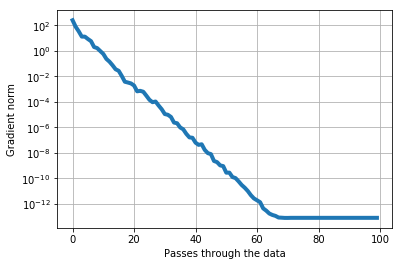

In [4]:
plt.plot(grad_history, lw=4)
plt.grid()
plt.yscale('log')
plt.ylabel('Gradient norm')
plt.xlabel('Passes through the data')
plt.show()

In [5]:
# .. time the algorithm ..
%timeit SAGA(A, b)

1 loop, best of 3: 2.43 s per loop


# Step 2. Just-in-time compilation

Python can be slow, specially in non-vectorized operations. However, it is possible to accelerate numerical computations in Python using the Numba library, as long as the computations depend exclusively on NumPy arrays (as is our case).

## Numba crash course

Consider a python function as the one below that adds component-wise two arrays a, b:

In [6]:
def add(p, q):
    c = np.zeros(p.size)
    for i in range(p.size):
        c[i] = p[i] + q[i]
    return c

p = np.random.randn(50000)
q = np.random.randn(50000)

%timeit add(p, q)

100 loops, best of 3: 16.1 ms per loop


This function only depends on the NumPy arrays a, b and so can be accelerated by Numba. For this all we need to do is to import "from numba import njit" and add "@njit" before the declaration of the function. This process is known as _decorating_ the function and "@njit" is the decorator.

In [7]:
from numba import njit

@njit
def add_jit(p, q):
    c = np.zeros(p.size)
    for i in range(p.size):
        c[i] = p[i] + q[i]
    return c

%timeit add_jit(p, q)

The slowest run took 2442.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 51.2 µs per loop


... and the resulting function is 500x times faster!

<img style="height: 200px" src="http://www.quickmeme.com/img/40/40b96f717103244d7d9dea023de22820619058efade0a529f2938430963ed6c7.jpg" />

# Now lets apply this to the SAGA algorithm above.

We copy-paste the algorithm and decorate the relevant functions with "@njit":

In [8]:
from numba import njit


@njit
def grad_jit(theta):
    return - np.dot(A.T, b - np.dot(A, theta))

@njit
def partial_grad_jit(theta, i):
    return - A[i] * (b[i] - np.dot(A[i], theta))

@njit
def SAGA_jit(A, b, max_iter=100):

    # .. initial guess (could be anything) ..
    theta_k = np.zeros(n_features)

    # .. initialization for historial gradients ..
    old_grad = np.zeros((n_samples, n_features))
    mean_grad = np.zeros(n_features)

    # .. to keep track of the gradient (for plotting purposes) ..
    grad_history = np.ones(max_iter)

    # .. main loop ..
    for i in range(n_samples * max_iter):
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)

        # .. compute saga update rule ..
        cur_grad = partial_grad_jit(theta_k, idx)
        mean_grad[:] = 0
        for j in range(n_samples):
            mean_grad += old_grad[j] / n_samples
        saga_update = cur_grad - old_grad[idx] + mean_grad

        # .. make update ..
        theta_k = theta_k - step_size * saga_update

        # .. save historical gradients ..
        old_grad[idx] = cur_grad

        # .. save gradient (for plotting purposes) every epoch ..
        if i % n_samples == 0:
            grad_history[i // n_samples] = np.linalg.norm(grad_jit(theta_k))

    return theta_k, grad_history

sol_jit, grad_history_jit = SAGA_jit(A, b)

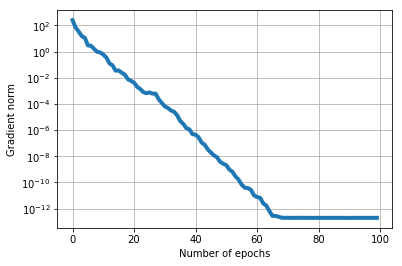

In [9]:
plt.plot(grad_history_jit, lw=4)
plt.grid()
plt.yscale('log')
plt.ylabel('Gradient norm')
plt.xlabel('Number of epochs')
plt.show()

In [10]:
# .. time the algorithm ..
%timeit SAGA_jit(A, b)

10 loops, best of 3: 189 ms per loop


That is again 20x times faster than the pure Python version. Nice!

# Step 3. Algorithmic and storage improvements.


**Algorithmic improvements**. Are all the computations in the above algorithm really necessary? E.g., do I need to compute $\bar{g}$ at each iteration? Can you identify other redundant operations?

<span style="color: red; font-weight: bold" />Task 1: modify the algorithm above to incrementally update $\bar{g}$ (mean_grad) instead of recomputing it.</span>



### Optional (if time permits)

**Reduced storage**. On of the biggest disadvantages of the SAGA algorithm is that it requires to store a table of past gradients. However, it is possible to reduce the storage of the historical gradients. For example, the partial gradients for least squares are:
$$
\nabla l_i(\theta) = - \underbrace{a_i^T}_{\text{ does not depend on $\theta$}} \underbrace{(b_i - a_i^T \theta)}_{\text{scalar}}
$$
and so it is only necesary to store the scalar part of the gradient. The true gradient will be computed when needed from the scalar part.

<span style="color: red; font-weight: bold" />Task 2: modify the algorithm to use this reduced storage scheme.</span>
